# Dataset Statistics for Gene Gene Sentences

This notebook is designed to show statistics on the data extracted from pubmed. The following cells below here are needed to set up the environment.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import Counter
from itertools import product
import os
import pickle
import sys

sys.path.append(os.path.abspath('../../../modules'))

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

sns.set(rc={'figure.figsize':(12,6), "font.size":17})

In [2]:
#Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmeddb"

#Path subject to change for different os
database_str = "postgresql+psycopg2://{}:{}@/{}?host=/var/run/postgresql".format(username, password, dbname)
os.environ['SNORKELDB'] = database_str

from snorkel import SnorkelSession
session = SnorkelSession()

In [3]:
from snorkel.models import candidate_subclass, Candidate
GeneGene = candidate_subclass('GeneGene', ['Gene1', 'Gene2'])

In [4]:
from utils.notebook_utils.dataframe_helper import write_candidates_to_excel, make_sentence_df

## Load and Merge DataFrames

In [5]:
edge_level_df = pd.read_table("input/gene_interacts_gene.tsv.xz")
edge_level_df.head(2)

,gene1_id,gene1_name,gene2_id,gene2_name,sources,n_sentences,hetionet,has_sentence,split,partition_rank
0,1,A1BG,10321,CRISP3,II_literature|hetio-dag,5,1,1,3,0.436432
1,125,ADH1B,10321,CRISP3,NaN,1,0,1,3,0.664368


In [8]:
sql = '''
select cand_id as candidate_id, gene1_id, gene2_id, sentence_id, text, array_length(words, 1) as sen_length from (
    select cand_id, "Gene1_cid" as gene1_id, "Gene2_cid" as gene2_id, sentence_id from (
        select gene_gene.id as "cand_id", gene_gene."Gene1_id",
        gene_gene."Gene1_cid", gene_gene."Gene2_cid", candidate.split from gene_gene 
        inner join candidate on gene_gene.id=candidate.id 
    ) as candidate_splits inner join span on candidate_splits."Gene1_id"=span.id
    ) as candidate_sen inner join sentence on candidate_sen.sentence_id=sentence.id
'''
candidate_sentence_df = pd.read_sql(sql, database_str).astype({"gene1_id":int, "gene2_id":int})

In [11]:
total_candidates_df = (
    edge_level_df
    .merge(candidate_sentence_df.astype({"gene1_id":int, "gene2_id":int}), on=["gene1_id", "gene2_id"])
)
total_candidates_df.head(2)

,gene1_id,gene1_name,gene2_id,gene2_name,sources,n_sentences,hetionet,has_sentence,split,partition_rank,candidate_id,sentence_id,text,sen_length
0,1,A1BG,10321,CRISP3,II_literature|hetio-dag,5,1,1,3,0.436432,12545979,46021215,Cysteine-rich secretory protein 3 is a ligand ...,13
1,1,A1BG,10321,CRISP3,II_literature|hetio-dag,5,1,1,3,0.436432,12655176,46021250,We demonstrate that CRISP-3 is a specific and ...,27


In [13]:
dev_candidates = (
    session
    .query(GeneGene)
    .filter(
        GeneGene.id.in_(
            total_candidates_df
            .query("split==4")
            .sample(10000, random_state=100)
            .candidate_id
            .tolist()
        )
    )
    .all()
)
dev_df = make_sentence_df(dev_candidates)
dev_df.head(2)

,candidate_id,gene1,gene2,gene1_id,gene2_id,sentence
0,26953,proinsulin,Insulin,3630,3630,"~~[[2 insulin 2]]~~ , ~~[[1 proinsulin 1]]~~ ,..."
1,27191,Ad2,Ad2,348,348,in both early ~~[[2 ad2 2]]~~ + nd1 and ~~[[1 ...


In [14]:
test_candidates = (
    session
    .query(GeneGene)
    .filter(
        GeneGene.id.in_(
            total_candidates_df
            .query("split==5")
            .sample(10000, random_state=120)
            .candidate_id
            .tolist()
        )
    )
    .all()
)
test_df = make_sentence_df(test_candidates)
test_df.head(2)

,candidate_id,gene1,gene2,gene1_id,gene2_id,sentence
0,26171,C-4,C-2,720,717,these results show the importance of the prima...
1,36030,EF-Tu,EF-Ts,7284,10102,the trypsin-cleaved ~~[[1 ef-tu 1]]~~ still ca...


In [15]:
#write_candidates_to_excel(dev_df, "../data/sentence/sentence_labels_dev.xlsx")
#write_candidates_to_excel(test_df, "../data/sentence/sentence_labels_test.xlsx")

## Distribution of Sentence Length

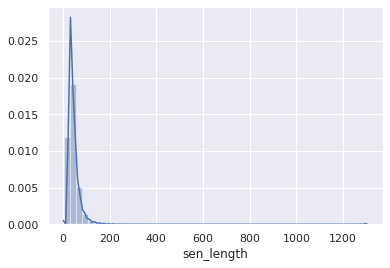

In [16]:
sns.distplot(total_candidates_df["sen_length"], rug=False)

In [17]:
total_candidates_df["sen_length"].describe().astype(int)

count    27178228
mean           42
std            25
min             3
25%            27
50%            37
75%            50
max          1304
Name: sen_length, dtype: int64

Something seems fishy about this distribution. The number of words (tokens) for a given sentence is in the thousands range. Intuitively, that doesn't make sense, since the average number of words for a given sentence is 37. Possible reason for this abnormality is a parsing error. Lets take a look at this 1120 word sentence.

In [18]:
total_candidates_df.query("sen_length==1304").iloc[0]["text"]

'The synthesis and magnetic properties of 13 new homo- and heterometallic Co(II) complexes containing the artificial amino acid 2-amino-isobutyric acid, aibH, are reported: [Co(II)(4)(aib)(3)(aibH)(3)(NO(3))](NO(3))(4)  2.8CH(3)OH  0.2H(2)O (1  2.8CH(3)OH  0.2H(2)O), {Na(2)[Co(II)(2)(aib)(2)(N(3))(4)(CH(3)OH)(4)]}(n) (2), [Co(II)(6)La(III)(aib)(6)(OH)(3)(NO(3))(2)(H(2)O)(4)(CH(3)CN)(2)]  0.5[La(NO(3))(6)]  0.75(ClO(4))  1.75(NO(3))  3.2CH(3)CN  5.9H(2)O (3  3.2CH(3)CN  5.9H(2)O), [Co(II)(6)Pr(III)(aib)(6)(OH)(3)(NO(3))(3)(CH(3)CN)(6)]  [Pr(NO(3))(5)]  0.41[Pr(NO(3))(3)(ClO(4))(0.5)(H(2)O)(1.5)]  0.59[Co(NO(3))(3)(H(2)O)]  0.2(ClO(4))  0.25H(2)O (4  0.25H(2)O), [Co(II)(6)Nd(III)(aib)(6)(OH)(3)(NO(3))(2.8)(CH(3)OH)(4.7)(H(2)O)(1.5)]  2.7(ClO(4))  0.5(NO(3))  2.26CH(3)OH  0.24H(2)O (5  2.26CH(3)OH  0.24H(2)O), [Co(II)(6)Sm(III)(aib)(6)(OH)(3)(NO(3))(3)(CH(3)CN)(6)]  [Sm(NO(3))(5)]  0.44[Sm(NO(3))(3)(ClO(4))(0.5)(H(2)O)(1.5)]  0.56[Co(NO(3))(3)(H(2)O)]  0.22(ClO(4))  0.3H(2)O (6  0.3H(2)O)

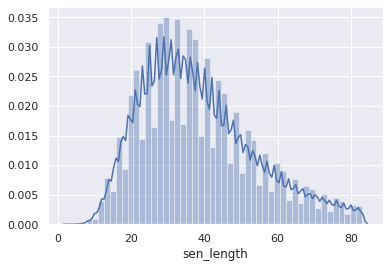

In [19]:
sns.distplot(total_candidates_df.query("sen_length < 83+1")["sen_length"], rug=False)

In [20]:
total_candidates_df.query("sen_length < 83+1")["sen_length"].describe().astype(int)

count    25657280
mean           38
std            15
min             3
25%            27
50%            36
75%            47
max            83
Name: sen_length, dtype: int64

This distribution looks a bit more reasonable compared to the above distribution. After filtering out the outliers, we still have a pleathora of sentences on the order of 12.9 million.

In [21]:
total_candidates_df.to_csv("output/all_gig_candidates.tsv.xz", sep="\t", index=False, compression="xz")

In conclusion, the optimal cutoff point in this case would be: **84** tokens/words or smaller depending on algorithm performance. Another important lesson is to analyze one's dataset before undergoing the journey of training a deep learning model. Sentence length is an important factor, when it comes to filtering out the dataset. If ignored, a significant amount of problems will arise. For example, when training a long short term memory network (LSTM), sequence length dictates how many steps the LSTM needs to traverse in order to ultimately calculate the probability of a sentence mentioning a relationship. If the LSTM were to be fed a sentence that contains 1120 words, then the network has 1120 steps to parse through. This takes a significant amount of time (~34 hours+). Plus during backpropogation, the gradient will become very small that the network cannot learn anything useful ([Backpropogation through time](https://en.wikipedia.org/wiki/Backpropagation_through_time)). 